# Pecs and Fat Segmentation v3

## Keras 2.0

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import SimpleITK as sitk
%matplotlib inline

In [2]:
from keras.models import Model, model_from_json
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Activation, Flatten
from keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy, mean_absolute_error, categorical_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger, BaseLogger, Callback, EarlyStopping, TensorBoard, LambdaCallback, ReduceLROnPlateau
from keras import backend as K
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


------------------

# 1. Reading Data & Pre-processing

CTSlices Shape: 
(1455, 512, 512)
Labels Shape: 
(1455, 512, 512)


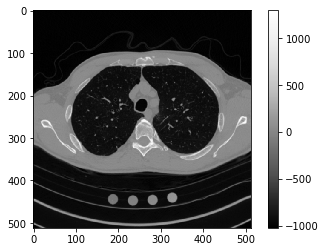

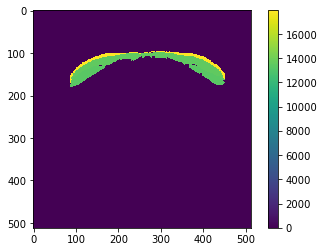

[    0 13335 13336 13591 13592 17943 17944]
(1455, 512, 512)


In [3]:
##-------------------------------------------------
## Reading Data
##-------------------------------------------------

folder = '/home/rmoreta/Projects/PectoralisSegmentation/Data/ProjectData_clean/'
num_files = [0] # 7 nrrd files in total

CTSlices = []
labels = []

# Reading CT
for i in num_files:
    if i == num_files[0]:
        # CTSlices
        file_name_CT = 'Cont_' + str(i+1) + '_clean.nrrd'#'_clean.nrrd'
        image_nrrd = sitk.ReadImage(folder + file_name_CT)
        CTSlices = sitk.GetArrayFromImage(image_nrrd)
        # Labels
        file_name_label = 'Cont_lm_' + str(i+1) + '_clean.nrrd'
        image_nrrd = sitk.ReadImage(folder + file_name_label)
        labels = sitk.GetArrayFromImage(image_nrrd)
    else:
        # CTSlices
        file_name_CT = 'Cont_' + str(i+1) + '_clean.nrrd'
        image_nrrd = sitk.ReadImage(folder + file_name_CT)
        CTSlices_aux = sitk.GetArrayFromImage(image_nrrd)
        CTSlices = np.concatenate((CTSlices, CTSlices_aux), axis = 0)
        # Labels
        file_name_label = 'Cont_lm_' + str(i+1) + '_clean.nrrd'
        image_nrrd = sitk.ReadImage(folder + file_name_label)
        labels_aux = sitk.GetArrayFromImage(image_nrrd)
        labels = np.concatenate((labels, labels_aux), axis = 0)
        
print('CTSlices Shape: ')
print(CTSlices.shape)

print('Labels Shape: ')
print(labels.shape)

# num_labels = np.unique(labels)

# Image Representation
slice_num = 300
ToraxSlice = CTSlices[slice_num,:,:]
plt.figure()
plt.imshow(ToraxSlice,cmap='Greys_r')
plt.colorbar()
plt.show()

LabelToraxSlice = labels[slice_num,:,:]
plt.figure()
plt.imshow(LabelToraxSlice)
plt.colorbar()
plt.show()
print(np.unique(LabelToraxSlice))

##-------------------------------------------------
## Normalazing
##-------------------------------------------------

numpy_array = CTSlices.astype(np.float32)
numpy_array[numpy_array < -1024] = -1024
numpy_array[numpy_array > 1500] = 1500
numpy_array = (numpy_array + 1024) / (1500 + 1024) - 0.5

CTSlices_new = numpy_array
print(CTSlices_new.shape)

------------------

**Selecting Labels**

(1455, 512, 512, 2)


/home/rmoreta/anaconda2/envs/tensorflow_2/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


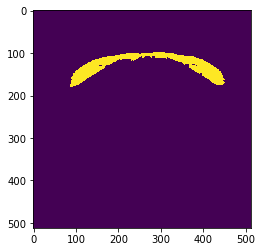

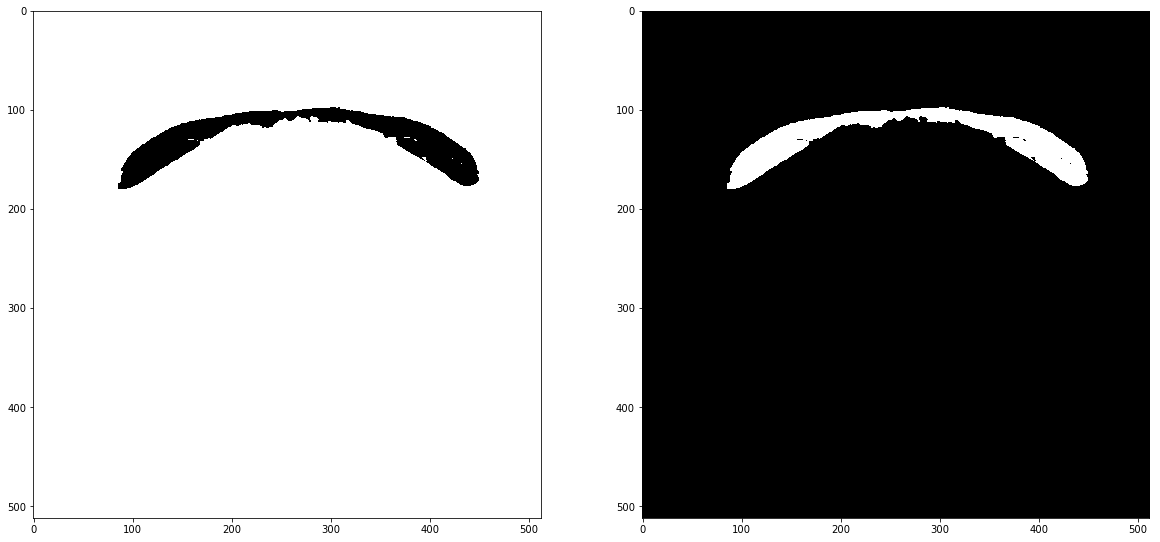

In [4]:
##-------------------------------------------------
## Selecting Labels
##-------------------------------------------------

num_classes = 2

labels[(labels!=13335)&(labels!=13336)&(labels!=13591)&(labels!=13592)&(labels!=17943)&(labels!=17944)] = 0
labels[(labels==13335)] = 1 # Left Minor Pectoral
labels[(labels==13336)] = 1 # Right Minor Pectoral
labels[(labels==13591)] = 1 # Left Major Pectoral
labels[(labels==13592)] = 1 # RIght Major Pectoral
labels[(labels==17943)] = 0 # Left Fat 
labels[(labels==17944)] = 0 # Right Fat 
plt.figure()
plt.imshow(labels[slice_num,:,:])
np.unique(labels[slice_num,:,:])

##-------------------------------------------------
## Transforming labels to categorical
##-------------------------------------------------

labels_cat = (np.arange(num_classes) == labels[:,:,:,None])
print(labels_cat.shape)

f, a = plt.subplots(1, num_classes, figsize=(20, 20))
for i in range(num_classes):
    a[i].imshow(labels_cat[slice_num,:,:,i],cmap='Greys_r')
f.show()
plt.draw()

-----------------

## Spliting data in Training And Testing

In [5]:
img_rows = 512 # Divisible por 16
img_cols = 512

num_images_train = 600
num_images_test = 50

train_dataset = CTSlices_new[0 : num_images_train,:,:]
train_labels = labels_cat[0 : num_images_train,:,:]
test_dataset = CTSlices_new[num_images_train : num_images_train+num_images_test,:,:]
test_labels = labels_cat[num_images_train : num_images_train+num_images_test,:,:]

print(train_dataset.shape)
print(train_labels.shape)
print(test_dataset.shape)
print(test_labels.shape)

(600, 512, 512)
(600, 512, 512, 2)
(50, 512, 512)
(50, 512, 512, 2)


--------------

## U-net Structure

**Loss Functions**

In [ ]:
def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

**Accuracy**

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)

In [ ]:
def IoU(y_true, y_pred):
    #y_true = K.flatten(y_true)
    #y_pred = K.flatten(y_pred)
    y_true = K.round(K.clip(y_true, 0, 1))
    y_pred = K.round(K.clip(y_pred, 0, 1))
    
    tp = K.sum(y_true * y_pred)
    print(tp.get_shape().as_list())
    fn = K.sum((y_true + y_pred)*y_true) - tp*2.
    fp = K.sum((y_true + y_pred)*y_pred) - tp*2.

    IoU = (tp)/(tp + fn + fp)
    return IoU

In [6]:
def IoU(y_true, y_pred):

    y_true = K.round(K.clip(y_true, 0, 1))
    y_pred = K.round(K.clip(y_pred, 0, 1))
    
    tp = K.sum(K.sum(K.sum((y_true * y_pred), axis=2),axis=1),axis=0)  
    fn = K.sum(K.sum(K.sum(((y_true + y_pred)*y_true), axis=2),axis=1),axis=0) - tp*2.
    fp = K.sum(K.sum(K.sum(((y_true + y_pred)*y_pred), axis=2),axis=1),axis=0) - tp*2.
    
    IoU = K.mean((tp)/(tp + fn + fp))
    
    return IoU

**List Of Parameters**

*Loss*

    binary_crossentropy
    categorical_crossentropy*
    mean_squared_error

*Optimizers*

    Adam(lr=, )
    SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)

*Accuracy*

    fbeta_score
    accuracy

#### U-Net Structure

In [22]:
def get_unet():
    
    inputs = Input((512, 512, 1))
    
    conv1 = Conv2D(32, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    
    conv5 = Conv2D(512, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv5)
    
    
    up6 = concatenate([Conv2D(256, (2, 2),  padding="same", kernel_initializer="glorot_normal", activation="relu")(UpSampling2D(size=(2, 2))(conv5)), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv6)

    up7 = concatenate([Conv2D(128, (2, 2),  padding="same", kernel_initializer="glorot_normal", activation="relu")(UpSampling2D(size=(2, 2))(conv6)), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv7)

    up8 = concatenate([Conv2D(64,(2, 2),  padding="same", kernel_initializer="glorot_normal", activation="relu")(UpSampling2D(size=(2, 2))(conv7)), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv8)

    up9 = concatenate([Conv2D(32,(2, 2),  padding="same", kernel_initializer="glorot_normal", activation="relu")(UpSampling2D(size=(2, 2))(conv8)), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv9)

    conv10 = Conv2D(num_classes, (1, 1), activation='sigmoid', kernel_initializer="glorot_normal")(conv9)
    
    
    model = Model(outputs=[conv10], inputs=inputs)

    model.compile(optimizer=Adam(lr=0.0001),loss=categorical_crossentropy, metrics=[IoU])
    
    print('U-net Initialized')

    return model

In [6]:
## Adding dopout
def get_unet_2():
    
    inputs = Input((512, 512, 1))
    
    drop_rate = 0.1
    
    conv1 = Conv2D(32, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(inputs)
    conv1 = Dropout(drop_rate)(conv1)
    conv1 = Conv2D(32, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(pool1)
    conv2 = Dropout(drop_rate)(conv2)
    conv2 = Conv2D(64, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(pool2)
    conv3 = Dropout(drop_rate)(conv3)
    conv3 = Conv2D(128, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(pool3)
    conv4 = Dropout(drop_rate)(conv4)
    conv4 = Conv2D(256, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    
    conv5 = Conv2D(512, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(pool4)
    conv5 = Dropout(drop_rate)(conv5)
    conv5 = Conv2D(512, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv5)
    
    
    up6 = concatenate([Conv2D(256, (2, 2),  padding="same", kernel_initializer="glorot_normal", activation="relu")(UpSampling2D(size=(2, 2))(conv5)), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(up6)
    conv6 = Dropout(drop_rate)(conv6)
    conv6 = Conv2D(256, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv6)

    up7 = concatenate([Conv2D(128, (2, 2),  padding="same", kernel_initializer="glorot_normal", activation="relu")(UpSampling2D(size=(2, 2))(conv6)), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(up7)
    conv7 = Dropout(drop_rate)(conv7)
    conv7 = Conv2D(128, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv7)

    up8 = concatenate([Conv2D(64,(2, 2),  padding="same", kernel_initializer="glorot_normal", activation="relu")(UpSampling2D(size=(2, 2))(conv7)), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(up8)
    conv8 = Dropout(drop_rate)(conv8)
    conv8 = Conv2D(64, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv8)

    up9 = concatenate([Conv2D(32,(2, 2),  padding="same", kernel_initializer="glorot_normal", activation="relu")(UpSampling2D(size=(2, 2))(conv8)), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(up9)
    conv9 = Dropout(drop_rate)(conv9)
    conv9 = Conv2D(32, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv9)

    conv10 = Conv2D(num_classes, (1, 1), activation='sigmoid', kernel_initializer="glorot_normal")(conv9)
    
    
    model = Model(outputs=[conv10], inputs=inputs)

    model.compile(optimizer=Adam(lr=0.001),loss=categorical_crossentropy, metrics=[IoU])
    
    print('U-net Initialized')

    return model

In [46]:
## Adding dopout
def get_unet_3():
    
    inputs = Input((512, 512, 1))
    
    drop_rate = 0.1
    
    conv1 = Conv2D(32, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(inputs)
    conv1 = Dropout(drop_rate)(conv1)
    conv1 = Conv2D(32, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(pool1)
    conv2 = Dropout(drop_rate)(conv2)
    conv2 = Conv2D(64, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(pool2)
    conv3 = Dropout(drop_rate)(conv3)
    conv3 = Conv2D(128, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(pool3)
    conv4 = Dropout(drop_rate)(conv4)
    conv4 = Conv2D(256, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    
    conv5 = Conv2D(512, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(pool4)
    conv5 = Dropout(drop_rate)(conv5)
    conv5 = Conv2D(512, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv5)
    
    
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(up6)
    conv6 = Dropout(drop_rate)(conv6)
    conv6 = Conv2D(256, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(up7)
    conv7 = Dropout(drop_rate)(conv7)
    conv7 = Conv2D(128, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(up8)
    conv8 = Dropout(drop_rate)(conv8)
    conv8 = Conv2D(64, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(up9)
    conv9 = Dropout(drop_rate)(conv9)
    conv9 = Conv2D(32, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv9)

    conv10 = Conv2D(num_classes, (1, 1), activation='sigmoid', kernel_initializer="glorot_normal")(conv9)
    
    
    model = Model(outputs=[conv10], inputs=inputs)

    model.compile(optimizer=Adam(lr=0.0001),loss=categorical_crossentropy, metrics=[IoU])
    
    print('U-net Initialized')

    return model

In [36]:
def get_autoencoder():
    
    inputs = Input((512, 512, 1))
    
    conv1 = Conv2D(32, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    
    conv5 = Conv2D(512, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv5)
    
    
    up6 = Conv2D(256, (2, 2),  padding="same", kernel_initializer="glorot_normal", activation="relu")(UpSampling2D(size=(2, 2))(conv5))
    conv6 = Conv2D(256, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv6)

    up7 = Conv2D(128, (2, 2),  padding="same", kernel_initializer="glorot_normal", activation="relu")(UpSampling2D(size=(2, 2))(conv6))
    conv7 = Conv2D(128, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv7)

    up8 = Conv2D(64,(2, 2),  padding="same", kernel_initializer="glorot_normal", activation="relu")(UpSampling2D(size=(2, 2))(conv7))
    conv8 = Conv2D(64, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv8)

    up9 = Conv2D(32,(2, 2),  padding="same", kernel_initializer="glorot_normal", activation="relu")(UpSampling2D(size=(2, 2))(conv8))
    conv9 = Conv2D(32, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", kernel_initializer="glorot_normal", activation="relu")(conv9)

    conv10 = Conv2D(num_classes, (1, 1), activation='sigmoid', kernel_initializer="glorot_normal")(conv9)
    
    
    model = Model(outputs=[conv10], inputs=inputs)

    model.compile(optimizer=Adam(lr=0.0001),loss=categorical_crossentropy, metrics=['accuracy'])
    
    print('Autoencoder Initialized')

    return model

In [ ]:
def get_unet_from_auto(weights):
    
    inputs = Input((512, 512, 1))
    
    conv1 = Conv2D(32, (3, 3), padding="same", 
                   kernel_initializer=init.Constant(weights[0]), bias_initializer=init.Constant(weights[1]), 
                   activation="relu")(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", 
                   kernel_initializer=init.Constant(weights[2]), bias_initializer=init.Constant(weights[3]),
                   activation="relu")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    
    conv2 = Conv2D(64, (3, 3), padding="same", 
                   kernel_initializer=init.Constant(weights[4]), bias_initializer=init.Constant(weights[5]),
                   activation="relu")(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", 
                   kernel_initializer=init.Constant(weights[6]), bias_initializer=init.Constant(weights[7]),
                   activation="relu")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    
    conv3 = Conv2D(128, (3, 3), padding="same", 
                   kernel_initializer=init.Constant(weights[8]), bias_initializer=init.Constant(weights[9]),
                   activation="relu")(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", 
                   kernel_initializer=init.Constant(weights[10]), bias_initializer=init.Constant(weights[11]),
                   activation="relu")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), padding="same", 
                   kernel_initializer=init.Constant(weights[12]), bias_initializer=init.Constant(weights[13]),
                   activation="relu")(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", 
                   kernel_initializer=init.Constant(weights[14]), bias_initializer=init.Constant(weights[15]),
                   activation="relu")(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    
    conv5 = Conv2D(512, (3, 3), padding="same", 
                   kernel_initializer=init.Constant(weights[16]), bias_initializer=init.Constant(weights[17]),
                   activation="relu")(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", 
                   kernel_initializer=init.Constant(weights[18]), bias_initializer=init.Constant(weights[19]),
                   activation="relu")(conv5)
    
    
    up6_aux = UpSampling2D(size=(2, 2))(conv5)
    conv6_aux = Conv2D(256, (2, 2),  padding="same", 
                      kernel_initializer=init.Constant(weights[20]), bias_initializer=init.Constant(weights[21]),
                      activation="relu")(up6_aux)
    up6 = concatenate([conv6_aux, conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), padding="same", 
                   kernel_initializer=init.Constant(weights[22]), bias_initializer=init.Constant(weights[23]),
                   activation="relu")(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", 
                   kernel_initializer=init.Constant(weights[24]), bias_initializer=init.Constant(weights[25]),
                   activation="relu")(conv6)
    
    up7_aux = UpSampling2D(size=(2, 2))(conv6)
    conv7_aux = Conv2D(128, (2, 2),  padding="same", 
                       kernel_initializer=init.Constant(weights[26]), bias_initializer=init.Constant(weights[27]),
                       activation="relu")(up7_aux)
    up7 = concatenate([conv7_aux, conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), padding="same", 
                   kernel_initializer=init.Constant(weights[28]), bias_initializer=init.Constant(weights[29]),
                   activation="relu")(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", 
                   kernel_initializer=init.Constant(weights[30]), bias_initializer=init.Constant(weights[31]),
                   activation="relu")(conv7)
    
    up8_aux = UpSampling2D(size=(2, 2))(conv7)
    conv8_aux = Conv2D(64,(2, 2),  padding="same", 
                       kernel_initializer=init.Constant(weights[32]), bias_initializer=init.Constant(weights[33]),
                       activation="relu")(up8_aux)
    up8 = concatenate([conv8_aux, conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), padding="same", 
                   kernel_initializer=init.Constant(weights[34]), bias_initializer=init.Constant(weights[35]),
                   activation="relu")(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", 
                   kernel_initializer=init.Constant(weights[36]), bias_initializer=init.Constant(weights[37]),
                   activation="relu")(conv8)
    
    up9_aux = UpSampling2D(size=(2, 2))(conv8)
    conv9_aux = Conv2D(32,(2, 2),  padding="same", 
                       kernel_initializer=init.Constant(weights[38]), bias_initializer=init.Constant(weights[39]),
                       activation="relu")(up9_aux)
    up9 = concatenate([conv9_aux, conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), padding="same", 
                   kernel_initializer=init.Constant(weights[40]), bias_initializer=init.Constant(weights[41]),
                   activation="relu")(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", 
                  kernel_initializer=init.Constant(weights[42]), bias_initializer=init.Constant(weights[43]),
                  activation="relu")(conv9)

    conv10 = Conv2D(num_classes, (1, 1), activation='sigmoid', 
                    kernel_initializer=init.Constant(weights[44]), bias_initializer=init.Constant(weights[45]))(conv9)
    
    
    model = Model(outputs=[conv10], inputs=inputs)

    model.compile(optimizer=Adam(lr=0.0001),loss=categorical_crossentropy, metrics=['accuracy'])
    
    print('U-net Initialized')

    return model

In [9]:
import keras.initializers as init
from keras import losses

In [ ]:
init.Constant()

----------

In [8]:
from keras.models import Model, model_from_json
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Activation, Flatten
from keras.layers.merge import concatenate
from keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy, mean_absolute_error, categorical_crossentropy, mean_squared_error
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger, BaseLogger, Callback, EarlyStopping, TensorBoard, LambdaCallback, ReduceLROnPlateau
from keras import backend as K
from keras.utils.np_utils import to_categorical

## Train

In [23]:
#img_rows = 512
#img_cols = 512
smooth = 1.

imgs_train = np.reshape(train_dataset,(num_images_train, img_rows, img_cols, 1))
imgs_mask_train = np.reshape(train_labels,(num_images_train, img_rows, img_cols, num_classes))
#imgs_mask_train = imgs_mask_train[:,:,:,1:]
total = imgs_train.shape[0]

print('Taining Shape:', imgs_train.shape)
print('Training Mask Shape:', imgs_mask_train.shape)

('Taining Shape:', (600, 512, 512, 1))
('Training Mask Shape:', (600, 512, 512, 2))


In [24]:
model = get_unet()

U-net Initialized


In [47]:
model = get_unet_3()

U-net Initialized


In [37]:
model = get_autoencoder()

Autoencoder Initialized


In [ ]:
model_u = get_unet_from_auto(w_auto)

#### Callbacks

In [11]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.IoU = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.IoU.append(logs.get('IoU'))

In [12]:
# Save model in .hdf5
path_unet = '/home/rmoreta/Projects/PectoralisSegmentation/Results/'
name_unet = 'unet_nc' + str(num_classes) + '_pecs_' + str(num_images_train) + 'prueba_k2' + '.hdf5'
model_checkpoint = ModelCheckpoint(path_unet + name_unet, monitor='loss',verbose=1, save_best_only=True)

# Create a CVS with the values of loss and accuracy at each epoch
model_CVSLogger = CSVLogger('hola.cvs', separator=',', append=True)

# Gets loss values at each batch and epoch in a list
history = LossHistory()

# Early Stopping 
model_EarlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

# Reduce LR
model_ReduceLROnPlateau = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=1, verbose=1, mode='auto', 
                  cooldown=0, min_lr=0.000001) # epsilon=0.0001

# Tensorboard
path_tb = '/home/rmoreta/Projects/PectoralisSegmentation/Results/tensorboard/log1/'
#model_TensorBoard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)

In [59]:
path_tb = '/home/rmoreta/Projects/PectoralisSegmentation/Results/tensorboard/log1'
model_TensorBoard = TensorBoard(log_dir=path_tb, histogram_freq=1, write_graph=True, write_images=True, 
                                embeddings_freq=1)

#### Train

In [30]:
model.compile(optimizer=Adam(lr=0.0001),loss=categorical_crossentropy, metrics=[IoU])

In [28]:
batch_size = 8
nb_epoch = 2

model.fit(imgs_train, imgs_mask_train, batch_size=batch_size, epochs=nb_epoch, 
          verbose=1, shuffle=True)# callbacks=[model_TensorBoard])


Epoch 1/2
600/600 [==============================] - 54s - loss: 0.0795 - IoU: 0.4837     

In [33]:
number_epochs = range(1)
for i in number_epochs:
    batch_size = 8
    nb_epoch = 3

    model.fit(imgs_train, imgs_mask_train, batch_size=batch_size, epochs=nb_epoch, 
          verbose=1, shuffle=True)# callbacks=[model_TensorBoard])
    

Epoch 1/3
600/600 [==============================] - 60s - loss: 0.0123 - IoU: 0.8648     

In [ ]:
model.get_weights()[16]

In [37]:
model.save(path_unet + 'pruebas_dropout_pecs_unet2.hdf5')

**Training Results**

*Losses Graphs*

In [ ]:
losses = np.array(history.losses)
batches = np.arange(losses.shape[0])

# Plot
plt.plot(batches,losses)
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title('Loss decay')
plt.show()

*Accuracy Graphs*

In [ ]:
accuracy = np.array(history.IoU)
batches = np.arange(accuracy.shape[0])

# Plot
plt.plot(batches,accuracy)
plt.xlabel('Batches')
plt.ylabel('Accuracy [%]')
plt.title('Accuracy')
plt.show()

#### Open trained U-net Model

    unet_GPU_multiclass_nc3_500im_17ep_lr001.hdf5
    unet_GPU_multiclass_nc5_1400im_16ep_lr001
    unet_GPU_multiclass_nc5_500im_6ep_lr001

In [191]:
from keras import models as models

In [ ]:
num_classes = 5

In [ ]:
path_unet = '/home/rmoreta/Projects/PectoralisSegmentation/Results/Unets/final/'
name_unet = 'unet_nc3_fat.hdf5'

In [ ]:
path_unet = '/home/rmoreta/Projects/PectoralisSegmentation/Results/Unets/final_keras2/'
name_unet = 'unet_nc' + str(num_classes) + '_fat' +'.hdf5'

In [ ]:
model = get_unet()
model.load_weights(path_unet + name_unet)

In [ ]:
model.save(path_unet + name_unet)

In [192]:
path_unet = '/home/rmoreta/Projects/PectoralisSegmentation/Results/Unets/final_keras2/'
model = models.load_model(path_unet + 'unet_nc5_pecs.hdf5')


In [ ]:
del model2

-----------------

-----------------

# Augmented Data limits in rotations

In [4]:
from scipy import ndimage
import cv2

In [108]:
path_unet = '/home/rmoreta/Projects/PectoralisSegmentation/Results/CARS_presentation/'
imgs_mask_test = np.load(path_unet + 'imgs_mask_test_pecs&fat_label.npy')
imgs_mask_pred = np.load(path_unet + 'imgs_mask_pred_pecs&fat_label.npy')
imgs_mask_pred = np.array(imgs_mask_pred, dtype='int8')
print('imgs_mask_test shape', imgs_mask_test.shape)
print('imgs_mask_pred shape', imgs_mask_pred.shape)

('imgs_mask_test shape', (3000, 512, 512, 6))
('imgs_mask_pred shape', (3000, 512, 512, 6))


In [98]:
def accuracy_IoU_np_individual(y_true, y_pred):
    axis = np.array((1,2))
    tp = np.apply_over_axes(np.sum,(y_true * y_pred), axes=axis)
    fn = np.apply_over_axes(np.sum,((y_true + y_pred)*y_true), axes=axis) - tp*2.
    fp = np.apply_over_axes(np.sum,((y_true + y_pred)*y_pred), axes=axis) - tp*2.
    
    #beta = 1
    #F_b = ((1+np.power(beta,2))*tp)/((1+np.power(beta,2))*tp + np.power(beta,2)*fn + fp)
    IoU = (tp)/(tp + fn + fp)
    
    return IoU

In [216]:
num_im = 100
num_classes = 6
angle_list = range(0,360,10)
mean_list = list()
for angle in angle_list:
    print angle
    print '-'*30
    ## Image Rotation
    print('Rotating images')
    imgs_mask_test_r = ndimage.rotate(imgs_mask_test[0:num_im], angle, reshape=False, axes=(1,2))
    imgs_mask_pred_r = ndimage.rotate(imgs_mask_pred[0:num_im], angle, reshape=False, axes=(1,2))

    ## Calculate IoU
    print('Calculating IoU')
    acc_test_image = accuracy_IoU_np_individual(imgs_mask_test_r, imgs_mask_pred_r)
    mean_list.append(np.mean(acc_test_image[:,0,0,:]))
    print(np.mean(acc_test_image[:,0,0,:]))



0
------------------------------
Rotating images
Calculating IoU
0.853575605809
10
------------------------------
Rotating images
Calculating IoU
0.85179902053
20
------------------------------
Rotating images
Calculating IoU
0.852072532644
30
------------------------------
Rotating images
Calculating IoU
0.852114124377
40
------------------------------
Rotating images
Calculating IoU
0.852237310836
50
------------------------------
Rotating images
Calculating IoU
0.851917755975
60
------------------------------
Rotating images
Calculating IoU
0.852081010134
70
------------------------------
Rotating images
Calculating IoU
0.851814887319
80
------------------------------
Rotating images
Calculating IoU
0.851790895981
90
------------------------------
Rotating images
Calculating IoU
0.853579490717
100
------------------------------
Rotating images
Calculating IoU
0.85179902053
110
------------------------------
Rotating images
Calculating IoU
0.852072532644
120
-------------------------

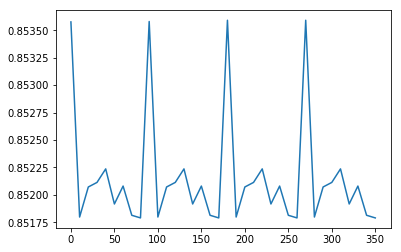

In [219]:
plt.figure()
plt.plot(angle_list,mean_list)

In [118]:
image = CTSlices[0:10,:,:]

In [119]:
image_r = ndimage.rotate(image,90,reshape=False, axes=(1,2))
image_r.shape

(10, 512, 512)

In [145]:
imgs_mask_test_r = ndimage.rotate(imgs_mask_test[1:2,:,:,0], 0, reshape=False, axes=(1,2))
imgs_mask_test_r.shape

(1, 512, 512)

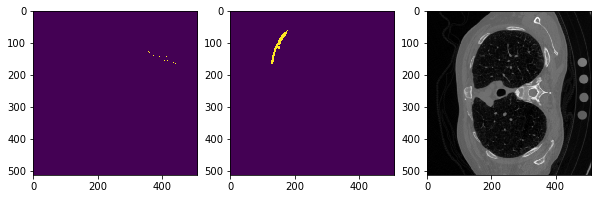

In [146]:
plt.figure()
im = 1
x, a =plt.subplots(1,3, figsize=(10,10))
a[0].imshow(imgs_mask_test_r[0,:,:])
a[1].imshow(imgs_mask_pred_r[im,:,:,0])
a[2].imshow(image_r[im,:,:], cmap='gray')

In [ ]:
f, a = plt.subplots(1, 1, figsize=(10, 7))
meanlineprops = dict(linestyle='--', linewidth=1, color='purple')
r = a.boxplot(acc_test_image, meanprops=meanlineprops, meanline=True,
                   showmeans=True)

## ticklabels
acc_test_image_mean_all = np.mean(acc_test_image,axis=0)
num_outlayers = list()
for i in range(6):
    num_outlayers.append(len(r["fliers"][i].get_data()[1])/3000.)

xticklabels_ = ('Left Minor Pec', 'Right Minor Pec', 'Left Major Pec', 'Right Major Pec', 'Left Fat', 'Right Fat')
xticklabels = list()
for i in range(6):
    xticklabels.append(xticklabels_[i] + '\n\n' + str(acc_test_image_mean_all[i])[0:6] + '\n\n' + str(num_outlayers[i])[0:6])
xticklabels = tuple(xticklabels)



a.set_xticklabels(xticklabels)
plt.title('Evaluation Results by Class - IoU = ' + str(np.mean(acc_test_image_mean_all)) + ' - num_outl = ' + str(np.mean(num_outlayers)))
plt.tight_layout()
plt.savefig(path_unet + "fig_1_allData.png", bbox_inches='tight')
plt.show()

In [ ]:
imgs_test = np.reshape(CTSlices_new[1500:1600],(num_images_test, 512, 512, 1))

In [222]:
CTSlices_new[1500:1600].shape

(0, 512, 512)

In [267]:
segm_type = 0
if segm_type == 0:
    classes = range(4)
elif segm_type == 0:
    classes = range(4,6)
    
num_images_test = 100
imgs_test = np.reshape(CTSlices_new[500:600],(num_images_test, 512, 512, 1))
imgs_mask_test_ = imgs_mask_test[500:600,:,:, classes]

In [304]:
acc_test_image_r = list()

angle_list = range(-90,90,1)

print '-'*30
print 'All Angles: ', angle_list
print '-'*30

for angle in angle_list:
    #angle = angle_list[0] 
    print 'Angle: ', angle
    ## 1. Rotate Images
    imgs_test_r = ndimage.rotate(imgs_test, angle, reshape=False, axes=(1,2))
    imgs_mask_test_r = ndimage.rotate(imgs_mask_test_, angle, reshape=False, axes=(1,2))

    ## 2. Predict
    print('Test Prediction')
    imgs_mask_pred_r = model.predict(imgs_test_r, verbose=1)

    ## 3. Calculate Performance Score
    print('Calculating IoU')
    acc_test_image = accuracy_IoU_np_individual(imgs_mask_test_r, imgs_mask_pred_r[:,:,:,1:])
    acc_test_image_r.append(acc_test_image)

    print(np.mean(acc_test_image[:,0,0]))
    print '-'*30
acc_test_image_r = np.array(acc_test_image_r)
acc_test_image_r = acc_test_image_r[:,:,0,0,:]

------------------------------
All Angles:  [-90, -89, -88, -87, -86, -85, -84, -83, -82, -81, -80, -79, -78, -77, -76, -75, -74, -73, -72, -71, -70, -69, -68, -67, -66, -65, -64, -63, -62, -61, -60, -59, -58, -57, -56, -55, -54, -53, -52, -51, -50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
Angle:  -90
Test Prediction
100/100 [==============================] - 2s     

In [305]:
np.save(path_unet + 'acc_test_image_r_-90-90-1.npy', acc_test_image_r)

In [306]:
acc_test_image_r.shape

(180, 100, 4)

IndexError: index 3 is out of bounds for axis 0 with size 3

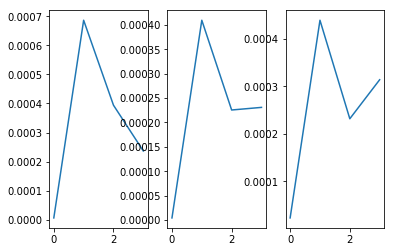

In [307]:
f,a = plt.subplots(1,3)
for i, angle in enumerate(angle_list):
    a[i].plot(np.mean(acc_test_image_r[i],axis=0))

In [299]:
acc_test_image_mean_all_r.shape

(18, 4)

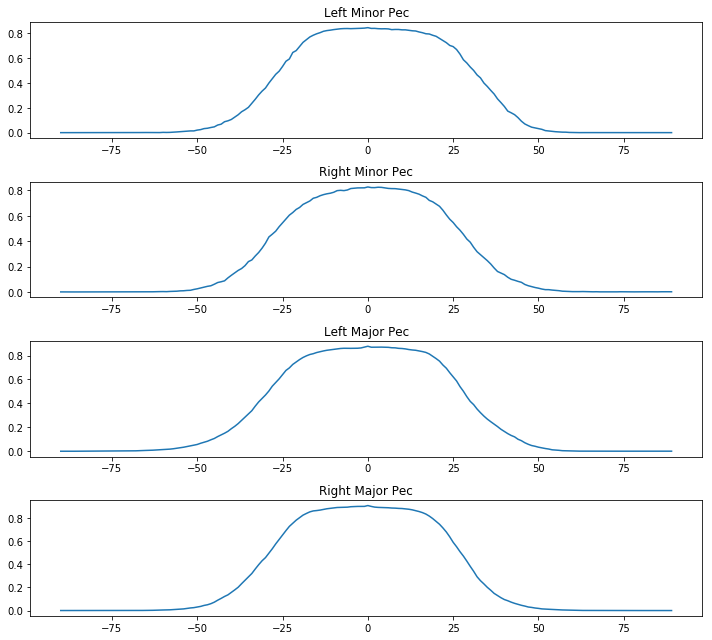

In [313]:
f, a = plt.subplots(4,1, figsize=(10, 9))
xticklabels_ = ('Left Minor Pec', 'Right Minor Pec', 'Left Major Pec', 'Right Major Pec')
acc_test_image_mean_all_r = np.mean(acc_test_image_r,axis=1)
for i, class_feat in enumerate(range(4)):
    a[i].plot(angle_list, acc_test_image_mean_all_r[:,class_feat])
    a[i].set_title(xticklabels_[i])
plt.tight_layout()

/home/rmoreta/anaconda2/envs/tensorflow_2/lib/python2.7/site-packages/matplotlib/legend.py:634: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)


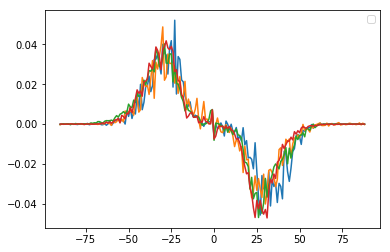

In [359]:
plt.figure()

for cls in range(len(classes)):
    y = acc_test_image_mean_all_r[:,cls]
    x = angle_list
    value = np.diff(y)/np.diff(angle_list)

    plt.plot(angle_list[:-1], value)

In [358]:
value.shape

(179,)

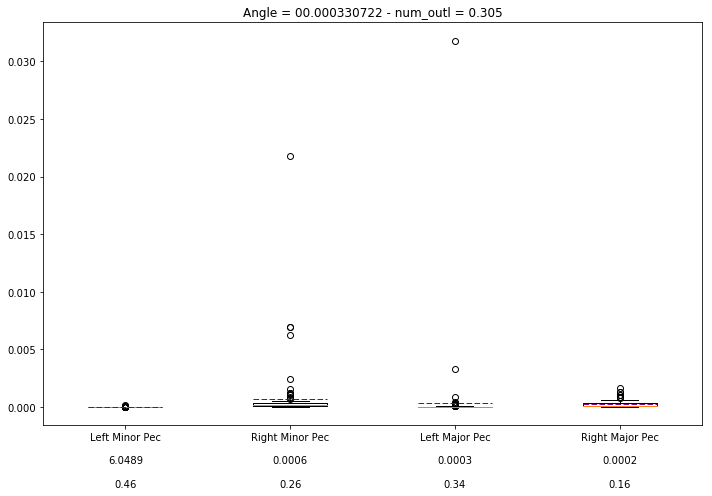

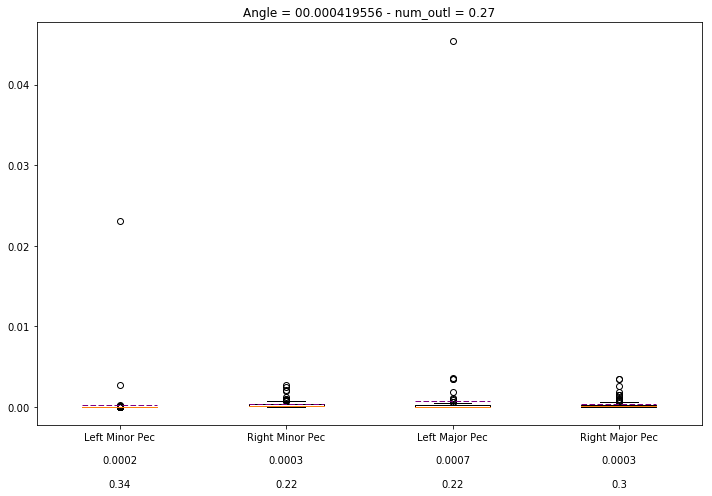

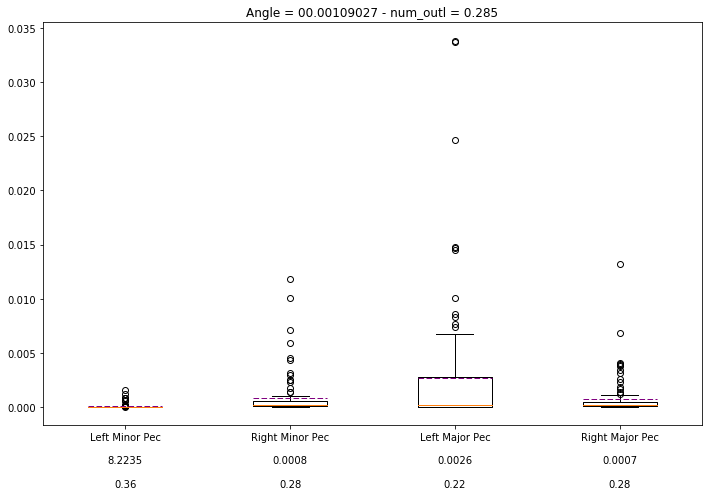

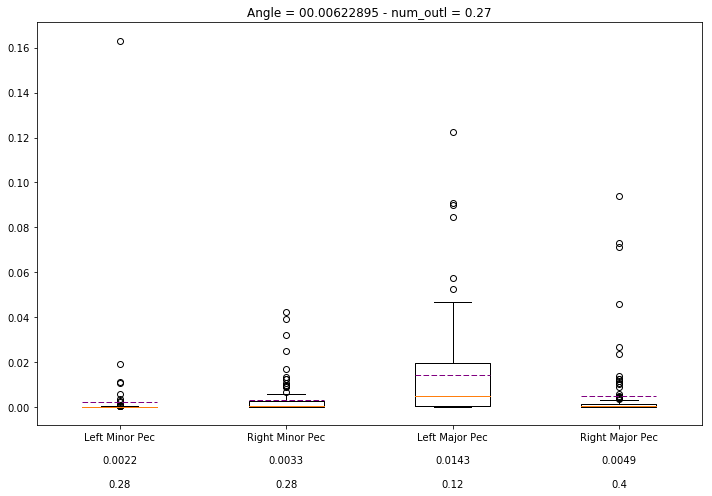

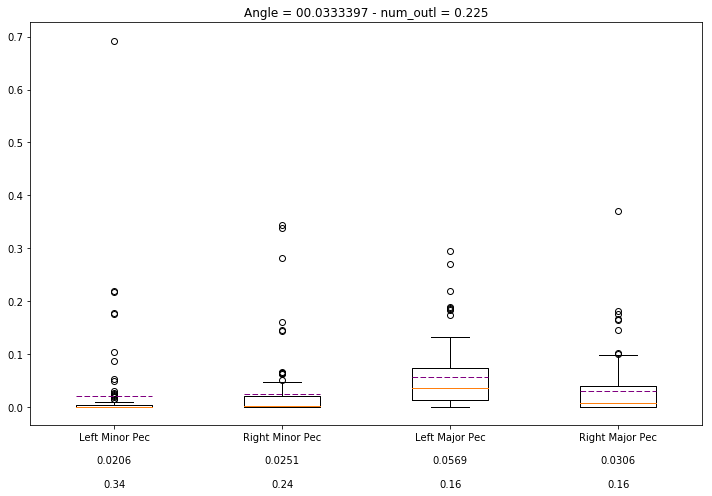

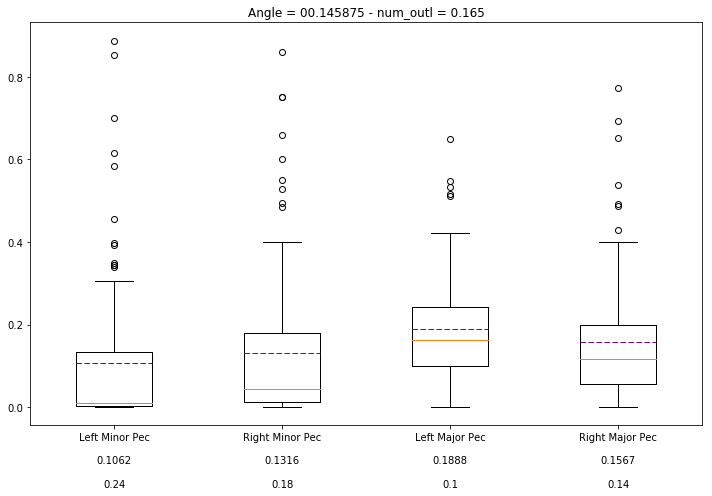

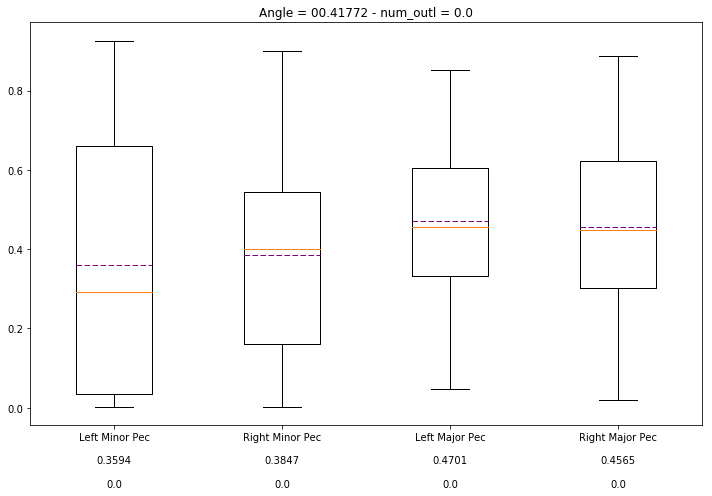

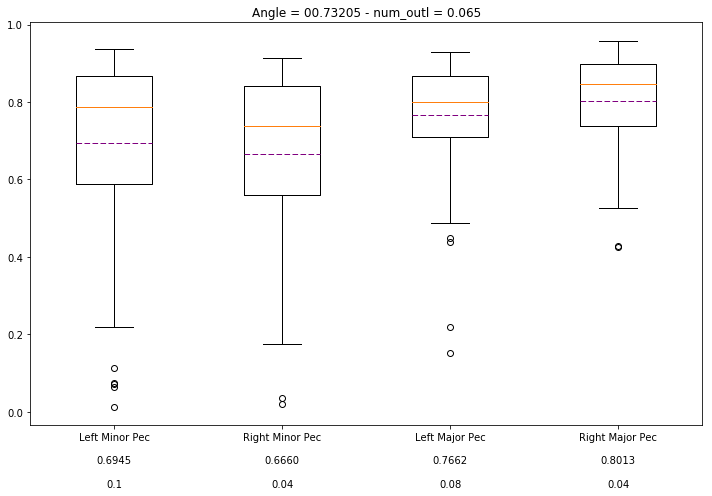

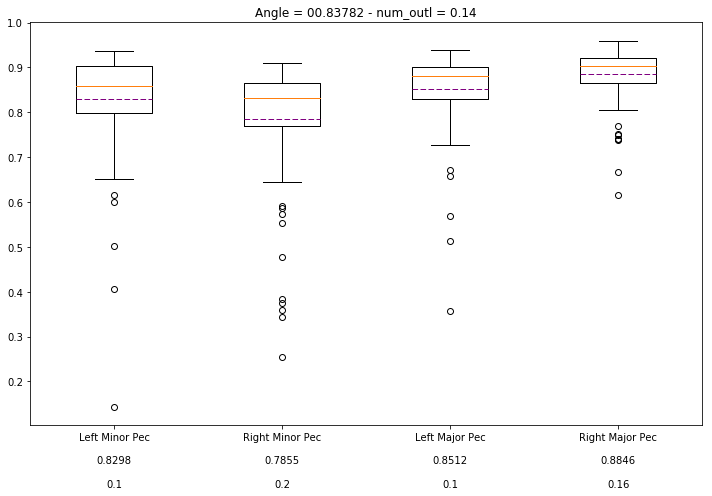

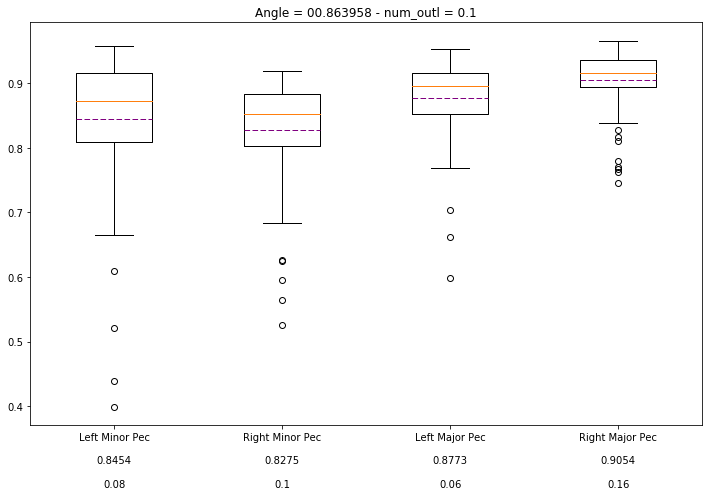

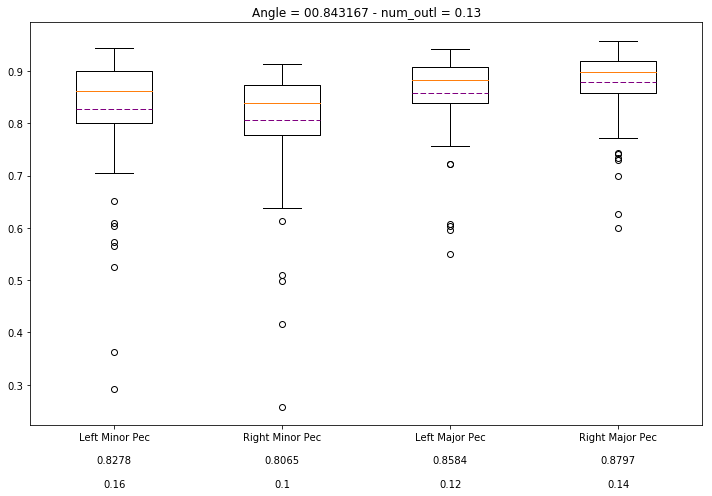

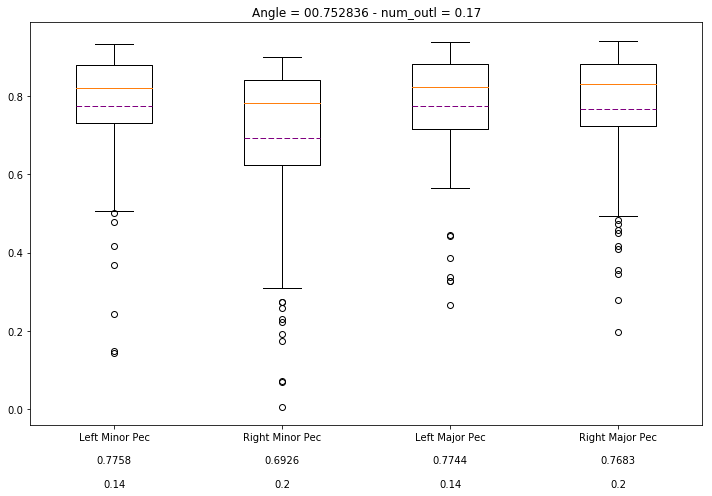

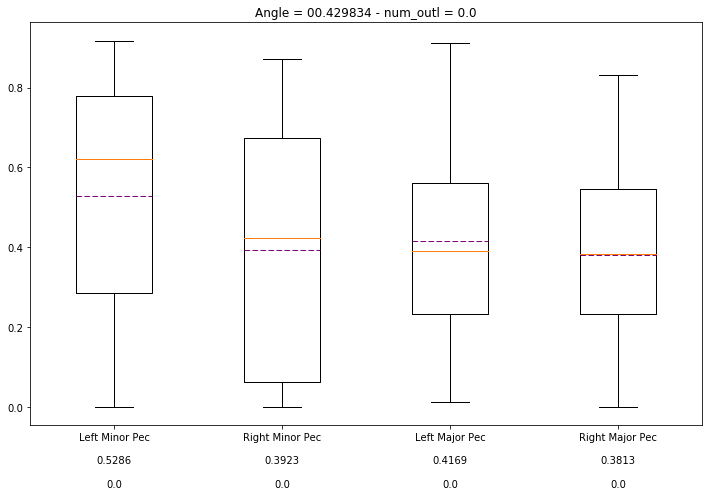

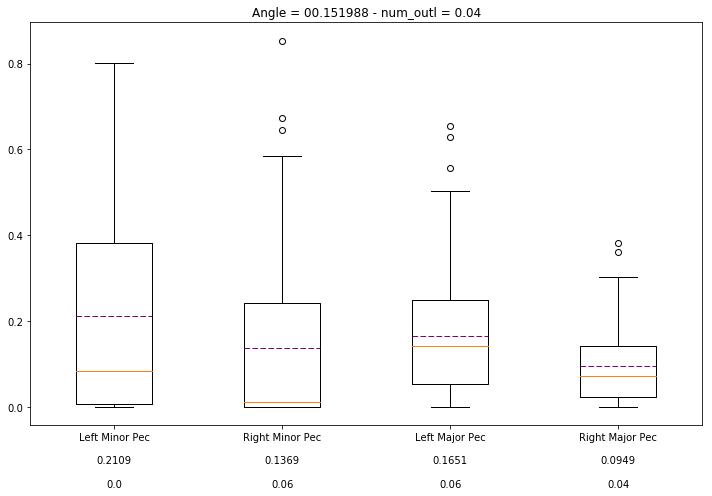

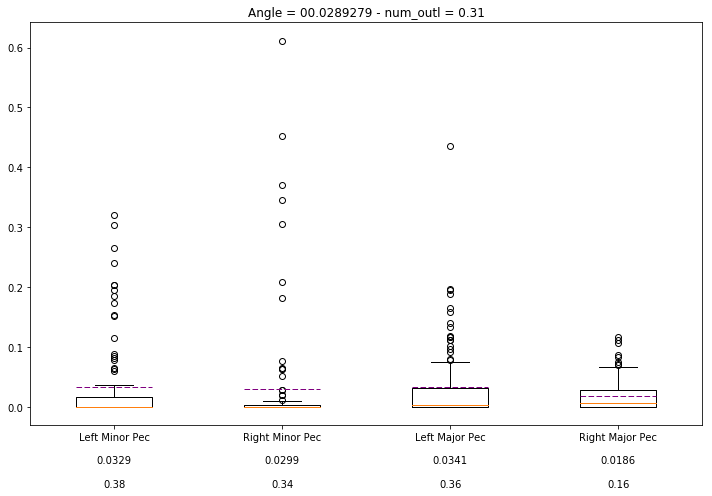

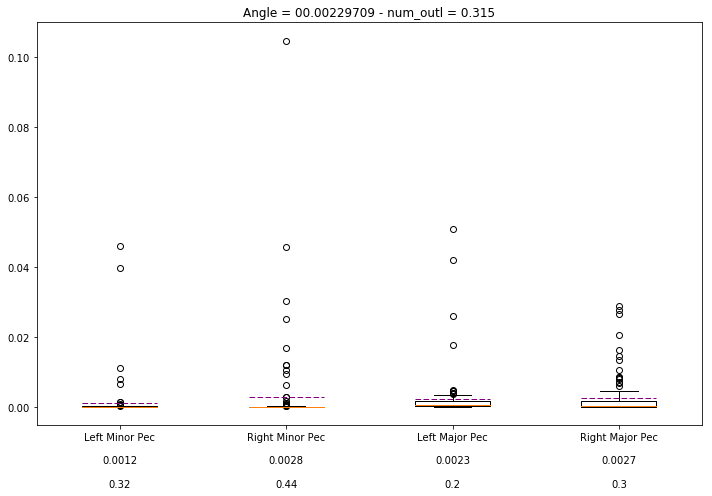

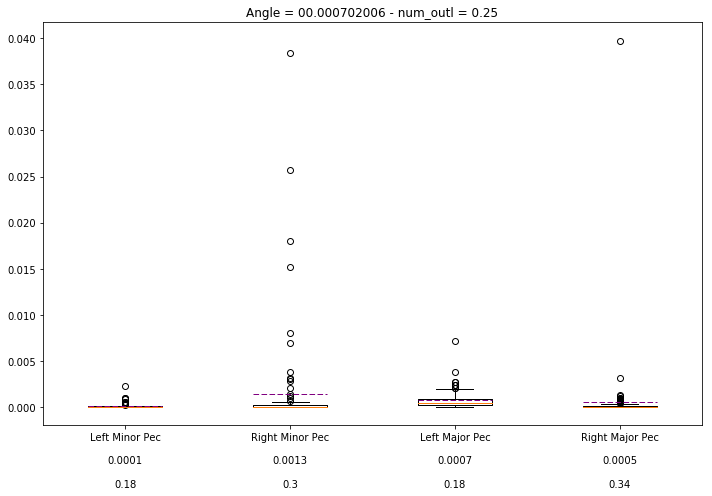

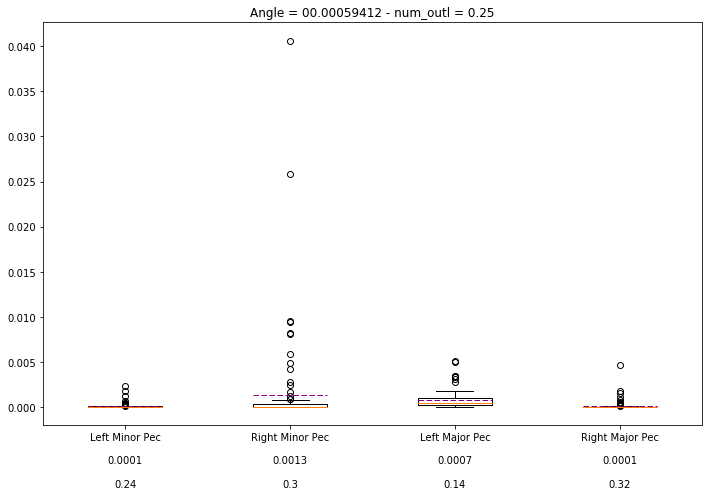

In [285]:
for ii in range(len(angle_list)):    
    f, a = plt.subplots(1, 1, figsize=(10, 7))
    meanlineprops = dict(linestyle='--', linewidth=1, color='purple')
    r = a.boxplot(acc_test_image_r[ii], meanprops=meanlineprops, meanline=True, showmeans=True)

    ## ticklabels
    acc_test_image_mean_all = np.mean(acc_test_image_r[ii],axis=0)
    num_outlayers = list()
    for i in range(4):
        num_outlayers.append(len(r["fliers"][i].get_data()[1])/50.)

    xticklabels_ = ('Left Minor Pec', 'Right Minor Pec', 'Left Major Pec', 'Right Major Pec')
    xticklabels = list()
    for i in range(4):
        xticklabels.append(xticklabels_[i] + '\n\n' + str(acc_test_image_mean_all[i])[0:6] + '\n\n' + str(num_outlayers[i])[0:6])
    xticklabels = tuple(xticklabels)



    a.set_xticklabels(xticklabels)
    plt.title('Angle = ' + str(angle_list[9]) + str(np.mean(acc_test_image_mean_all)) + ' - num_outl = ' + str(np.mean(num_outlayers)))
    plt.tight_layout()
    #plt.savefig(path_unet + "fig_1_allData.png", bbox_inches='tight')
plt.show()

In [164]:
imgs_test_r.shape

(512, 512)

In [176]:
imgs_mask_test = np.array(imgs_mask_test, dtype='int8')

IndexError: index 6 is out of bounds for axis 3 with size 6

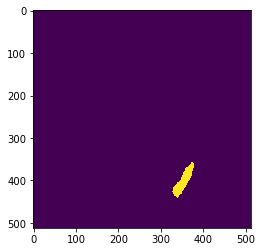

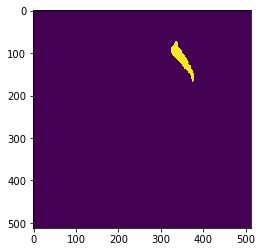

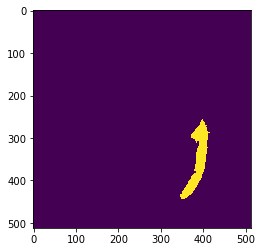

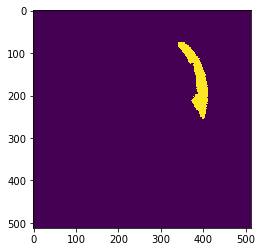

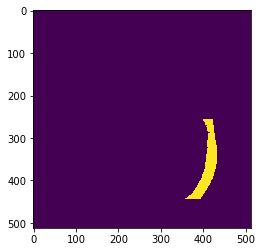

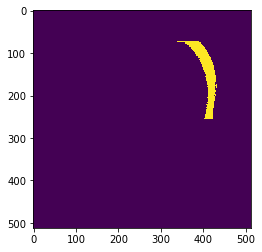

In [189]:
angle_list = range(-45,45,5)

for i,angle in enumerate(angle_list):
    #imgs_test_r = ndimage.rotate(imgs_mask_test[0:,:,:,3], angle, reshape=False, axes=(0,1))
    plt.figure()
    plt.imshow(imgs_mask_test_r[0,:,:,i])

-----------------

-----------------

## Test

In [14]:
#img_rows = 512
#img_cols = 512

imgs_test = np.reshape(test_dataset,(num_images_test, img_rows, img_cols, 1))
imgs_mask_test = np.reshape(test_labels,(num_images_test, img_rows, img_cols, num_classes))

print('Test Shape: ', imgs_test.shape)
print('Test Mask Shape: ', imgs_mask_test.shape)

('Test Shape: ', (50, 512, 512, 1))
('Test Mask Shape: ', (50, 512, 512, 2))


In [29]:
# Test Prediction
print('Test Prediction')
imgs_mask_pred = model.predict(imgs_test, verbose=1)

# Test
print('Test Evaluation')
test_evaluation = model.evaluate(imgs_test, imgs_mask_test, verbose=1)

# Saving prediction results
#np.save('imgs_mask_pred_test.npy', imgs_mask_pred)

print('Test loss:', test_evaluation[0])
print('Test accuracy:', test_evaluation[1])

Test Prediction
50/50 [==============================] - 1s     
Test Evaluation
50/50 [==============================] - 1s     
('Test loss:', 0.045504293739795684)
('Test accuracy:', 0.48144290685653685)


In [ ]:
auxiliar = np.copy(imgs_mask_pred)

In [ ]:
th = 0.5
imgs_mask_pred = np.copy(auxiliar)
imgs_mask_pred[(imgs_mask_pred > th)] = 1
imgs_mask_pred[(imgs_mask_pred < th)] = 0

In [ ]:
imgs_mask_pred = imgs_mask_pred.astype('int16')

In [ ]:
labels_closed_cat = np.zeros((50,512,512,num_classes-1))
for i,ii in enumerate([1,2]):
    for j in range(50):
        aux = sitk.GetImageFromArray(imgs_mask_pred[j,:,:,ii])
        imgs_mask_pred[j,:,:,i] = sitk.GetArrayFromImage(sitk.BinaryFillhole(aux))


In [ ]:
j = 40
ii = 1

plt.figure()
plt.imshow(imgs_mask_pred[j,:,:,ii])
plt.figure()
plt.imshow(labels_closed_cat[j,:,:,ii-1])


In [ ]:
imgs_mask_pred_join = np.zeros(labels_closed_cat.shape[0:-1])
class_code = [5,6]

for i in np.linspace(num_classes - 1, 1, num_classes - 1, dtype='int16'):
    imgs_mask_pred_join = unify_labels(labels_closed_cat[:, :, :, i-1], imgs_mask_pred_join, class_code[i-1])

In [ ]:
plt.figure()
plt.imshow(imgs_mask_pred_join[40,:,:])

In [ ]:
imgs_mask_pred.shape

** Load fat and pecs **

In [ ]:
path_unets = '/home/rmoreta/Projects/PectoralisSegmentation/Results/'
imgs_mask_pred = np.load(path_unets + 'imgs_mask_pred_test_pecs.npy')
imgs_pred_fat = np.load(path_unets + 'imgs_mask_pred_test_fat.npy')

In [ ]:
imgs_mask_pred = np.concatenate((imgs_mask_pred,imgs_pred_fat[:,:,:,[1,2]]), axis = 3)

In [ ]:
np.save(path_unets + 'imgs_mask_pred_test_pecs&fat.npy', imgs_mask_pred)

----------------

## Results

In [ ]:
#imgs_mask_pred = np.load('imgs_mask_pred_ADAM-lr=001__loss=binary_crossentropy.npy')
np.unique(imgs_mask_pred)

In [ ]:
print(np.unique(np.sum(imgs_mask_pred,axis=3)))
print(np.sum(imgs_mask_pred[:,:,:,2]*imgs_mask_pred[:,:,:,0]))


### Test Results

*Each Class*

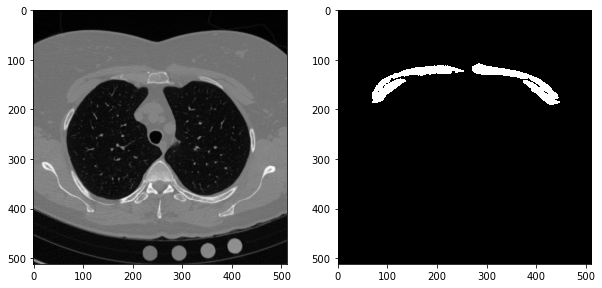

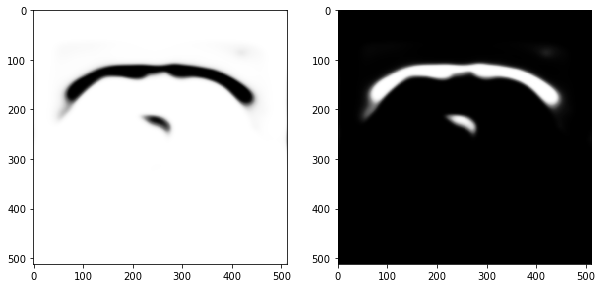

In [30]:
for i in [0]:
    f, a = plt.subplots(1, num_classes, figsize=(10, 10))
    f2, a2 = plt.subplots(1, num_classes, figsize=(10, 10))
    a[1].imshow(imgs_mask_test[i,:,:,1], cmap='Greys_r')
    #a[2].imshow(imgs_mask_test[i,:,:,2], cmap='Greys_r')
    a[0].imshow(imgs_test[i,:,:,0], cmap='Greys_r')
    a2[0].imshow(imgs_mask_pred[i,:,:,0], cmap='Greys_r')
    a2[1].imshow(imgs_mask_pred[i,:,:,1], cmap='Greys_r')
    #a2[2].imshow(imgs_mask_pred[i,:,:,2], cmap='Greys_r')
    f.show()
    f2.show()
    plt.draw()

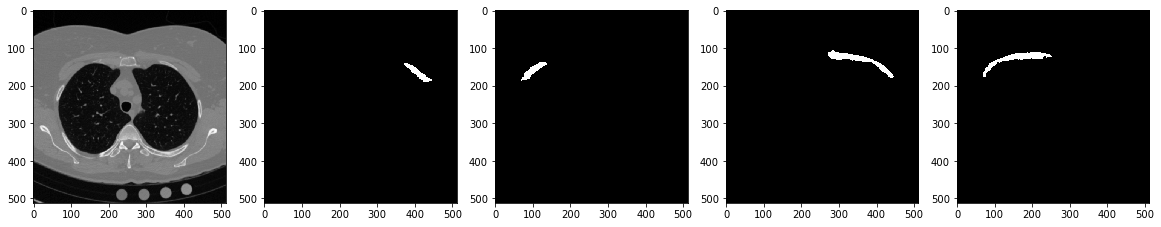

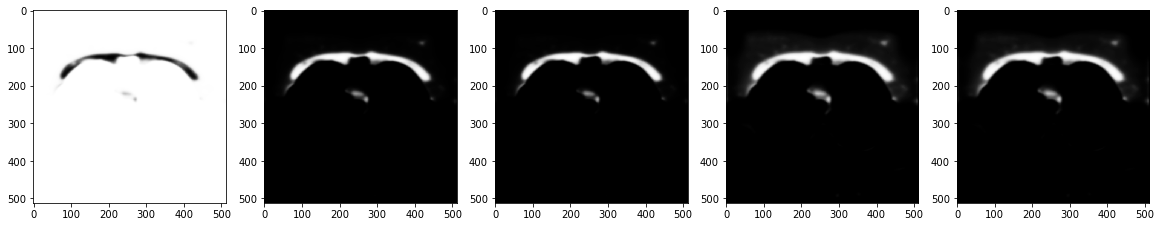

In [16]:
for i in [0]:
    f, a = plt.subplots(1, num_classes, figsize=(20, 20))
    f2, a2 = plt.subplots(1, num_classes, figsize=(20, 20))
    a[1].imshow(imgs_mask_test[i,:,:,1], cmap='Greys_r')
    a[2].imshow(imgs_mask_test[i,:,:,2], cmap='Greys_r')
    a[0].imshow(imgs_test[i,:,:,0], cmap='Greys_r')
    a[3].imshow(imgs_mask_test[i,:,:,3], cmap='Greys_r')
    a[4].imshow(imgs_mask_test[i,:,:,4], cmap='Greys_r')
    
    a2[0].imshow(imgs_mask_pred[i,:,:,0], cmap='Greys_r')
    a2[1].imshow(imgs_mask_pred[i,:,:,1], cmap='Greys_r')
    a2[2].imshow(imgs_mask_pred[i,:,:,2], cmap='Greys_r')
    a2[3].imshow(imgs_mask_pred[i,:,:,3], cmap='Greys_r')
    a2[4].imshow(imgs_mask_pred[i,:,:,4], cmap='Greys_r')
    f.show()
    f2.show()
    plt.draw()

In [ ]:
for i in range(3):
    f, a = plt.subplots(1, num_classes, figsize=(20, 20))
    f2, a2 = plt.subplots(1, num_classes, figsize=(20, 20))
    a[1].imshow(imgs_mask_test[i,:,:,1], cmap='Greys_r')
    a[2].imshow(imgs_mask_test[i,:,:,2], cmap='Greys_r')
    a[0].imshow(imgs_test[i,:,:,0], cmap='Greys_r')
    #a[3].imshow(imgs_mask_test[i,:,:,3], cmap='Greys_r')
    #a[4].imshow(imgs_mask_test[i,:,:,4], cmap='Greys_r')
    
    a2[0].imshow(imgs_mask_pred[i,:,:,0], cmap='Greys_r')
    a2[1].imshow(imgs_mask_pred[i,:,:,1], cmap='Greys_r')
    a2[2].imshow(imgs_mask_pred[i,:,:,2], cmap='Greys_r')
    #a2[3].imshow(imgs_mask_pred[i,:,:,3], cmap='Greys_r')
    #a2[4].imshow(imgs_mask_pred[i,:,:,4], cmap='Greys_r')
    f.show()
    f2.show()
    plt.draw()

In [ ]:
for i in [0,1,4,6,8,9,21,3,2]:
    f, a = plt.subplots(1, num_classes, figsize=(20, 20))
    f2, a2 = plt.subplots(1, num_classes, figsize=(20, 20))
    a[1].imshow(imgs_mask_test[i,:,:,1], cmap='Greys_r')
    a[2].imshow(imgs_mask_test[i,:,:,2], cmap='Greys_r')
    a[0].imshow(imgs_test[i,:,:,0], cmap='Greys_r')
    a[3].imshow(imgs_mask_test[i,:,:,3], cmap='Greys_r')
    a[4].imshow(imgs_mask_test[i,:,:,4], cmap='Greys_r')
    a[5].imshow(imgs_mask_test[i,:,:,5], cmap='Greys_r')
    a[6].imshow(imgs_mask_test[i,:,:,6], cmap='Greys_r')
    
    a2[0].imshow(imgs_mask_pred[i,:,:,0], cmap='Greys_r')
    a2[1].imshow(imgs_mask_pred[i,:,:,1], cmap='Greys_r')
    a2[2].imshow(imgs_mask_pred[i,:,:,2], cmap='Greys_r')
    a2[3].imshow(imgs_mask_pred[i,:,:,3], cmap='Greys_r')
    a2[4].imshow(imgs_mask_pred[i,:,:,4], cmap='Greys_r')
    a2[5].imshow(imgs_mask_pred[i,:,:,5], cmap='Greys_r')
    a2[6].imshow(imgs_mask_pred[i,:,:,6], cmap='Greys_r')
    
    f.show()
    f2.show()
    plt.draw()

In [ ]:
import scipy.misc

*Join Together*

In [ ]:
def unify_labels(labels, labels_unique, code):
    condition = (labels == 1)
    index = np.where(condition)
    labels_unique[index] = code

    return labels_unique

In [ ]:
np.linspace(num_classes - 1, 1, num_classes - 1, dtype='int16')

In [ ]:
imgs_mask_pred.shape

In [ ]:
imgs_mask_pred_join = np.zeros(imgs_mask_pred.shape[0:-1])
class_code = [1,2,3,4,5,6]

#th = 0.5
aux = np.copy(imgs_mask_pred)
#aux[(aux > th)] = 1
#aux[(aux < th)] = 0

for i in np.linspace(num_classes - 1, 1, num_classes - 1, dtype='int16'):
    imgs_mask_pred_join = unify_labels(aux[:, :, :, i], imgs_mask_pred_join, class_code[i-1])

In [ ]:
imgs_mask_pred.shape

In [ ]:
imgs_mask_pred_join = np.copy(imgs_mask_pred)
imgs_mask_pred_join[:,:,:,2] = imgs_mask_pred_join[:,:,:,2]*2
imgs_mask_pred_join[:,:,:,3] = imgs_mask_pred_join[:,:,:,3]*3
imgs_mask_pred_join[:,:,:,4] = imgs_mask_pred_join[:,:,:,4]*4
imgs_mask_pred_join = np.sum(imgs_mask_pred_join[:,:,:,1:num_classes], axis = 3)

In [ ]:
for i in images_good_classes:
    f, a = plt.subplots(1, 3, figsize=(20, 20))
    a[1].imshow(imgs_mask_pred_join[i,:,:])
    a[2].imshow(labels[num_images_train+i,:,:])
    a[0].imshow(imgs_test[i,:,:,0],cmap='Greys_r')
    f.show()
    plt.title(str(i))
    plt.draw()
    plt.savefig(path_unets + 'Figures/all_subplot_good{}.png'.format(i))
    #scipy.misc.imsave('Figures/Multiclass/Best/all_mask_pred_{}.png'.format(i),imgs_mask_pred[i,:,:,0])
    #scipy.misc.imsave('Figures/Multiclass/Best/all_test_{}.png'.format(i),imgs_mask_test[i,:,:,0])
    #scipy.misc.imsave('Figures/Multiclass/Best/all_mask_test{}.png'.format(i),imgs_test[i,:,:,0])

In [ ]:
imgs_mask_pred_join = np.copy(imgs_mask_pred)
imgs_mask_pred_join[:,:,:,2] = imgs_mask_pred_join[:,:,:,2]*2
imgs_mask_pred_join = np.sum(imgs_mask_pred_join[:,:,:,1:3], axis = 3)

for i in [0]:
    f, a = plt.subplots(1, 3, figsize=(20, 20))
    a[1].imshow(imgs_mask_pred_join[i,:,:], cmap='Greys_r')
    a[2].imshow(labels[num_images_train+i,:,:],cmap='Greys_r')
    a[0].imshow(imgs_test[i,:,:,0],cmap='Greys_r')
    f.show()
    plt.draw()

--------

** Accuracy over all test images**

In [ ]:
def accuracy_IoU_np_all(y_true, y_pred):
    tp = np.sum(y_true * y_pred)
    fn = np.sum((y_true + y_pred)*y_true) - tp*2.
    fp = np.sum((y_true + y_pred)*y_pred) - tp*2.
    
    #beta = 1
    #F_b = ((1+np.power(beta,2))*tp)/((1+np.power(beta,2))*tp + np.power(beta,2)*fn + fp)
    IoU = (tp)/(tp + fn + fp)
    
    return IoU

In [ ]:
def accuracy_IoU_np(y_true, y_pred):
    axis = np.array((2,1,0))
    tp = np.apply_over_axes(np.sum,(y_true * y_pred), axes=axis)
    fn = np.apply_over_axes(np.sum,((y_true + y_pred)*y_true), axes=axis) - tp*2.
    fp = np.apply_over_axes(np.sum,((y_true + y_pred)*y_pred), axes=axis) - tp*2.
    
    #beta = 1
    #F_b = ((1+np.power(beta,2))*tp)/((1+np.power(beta,2))*tp + np.power(beta,2)*fn + fp)
    IoU = (tp)/(tp + fn + fp)
    return IoU

In [ ]:
th = 0.5
#imgs_mask_pred = np.load('imgs_mask_pred_test.npy')
#imgs_mask_pred[(imgs_mask_pred>th)] = 1
#imgs_mask_pred[(imgs_mask_pred<th)] = 0

acc_test = accuracy_IoU_np(imgs_mask_test,imgs_mask_pred)
acc_test = acc_test[0,0,0,:]

#print(acc_test)
for i in range(num_classes):
    print(('Test Accuracy Class ' + str(i) + ': '), acc_test[i])
print('Test Accuracy Class Mean ', np.mean(acc_test))
print('Test Accuracy Over all ', accuracy_IoU_np_all(imgs_mask_test,imgs_mask_pred))

# PLot
ind = np.arange(num_classes)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, acc_test, width, color='r')

# add some text for labels, title and axes ticks
ax.set_ylabel('Accuracy [%]')
ax.set_title('Accuracy by Class')
ax.set_xticks(ind+width/2.)
ax.set_xticklabels(('C0', 'C1', 'C2', 'C3', 'C4'))
plt.show()
#fig.savefig('Figures/Multiclass/c5_accuracy_images_barchar.png')

**Accuracy over each test image**

In [ ]:
def accuracy_IoU_np_individual(y_true, y_pred):
    axis = np.array((1,2))
    tp = np.apply_over_axes(np.sum,(y_true * y_pred), axes=axis)
    fn = np.apply_over_axes(np.sum,((y_true + y_pred)*y_true), axes=axis) - tp*2.
    fp = np.apply_over_axes(np.sum,((y_true + y_pred)*y_pred), axes=axis) - tp*2.
    
    #beta = 1
    #F_b = ((1+np.power(beta,2))*tp)/((1+np.power(beta,2))*tp + np.power(beta,2)*fn + fp)
    IoU = (tp)/(tp + fn + fp)
    
    return IoU

In [ ]:
th = 0.5
#imgs_mask_pred = np.load('imgs_mask_pred_test.npy')
imgs_mask_pred[(imgs_mask_pred>th)] = 1
imgs_mask_pred[(imgs_mask_pred<th)] = 0

acc_test_image = accuracy_IoU_np_individual(imgs_mask_test[0:1000],imgs_mask_pred[0:1000])
print(acc_test_image[1,0,0,:])

## Plot 
#images = np.arange(num_images_test)
images = np.arange(1000)
f, a = plt.subplots(1, num_classes, figsize=(15, 4))
for i in range(num_classes):
    # Class i
    a[i].plot(images,acc_test_image[:,0,0,i], 'o')
    #a[i].xlabel('Test Images')
    #a[i].ylabel(('Accuracy Class ' + str(i)))
    #a[i].title('Accuracy for each Test Image')
    f.show()
    print(('Test Accuracy Class ' + str(i) + ': '), np.mean(acc_test_image[:,0,0,i]))
#f.savefig('Figures/Multiclass/c5_accuracy_images.png')

In [ ]:
## Plot 
#images = np.arange(num_images_test)
images = np.arange(1000)
f, a = plt.subplots(1, num_classes, figsize=(15, 4))
for i in range(num_classes):
    # Class i
    a[i].plot(images,acc_test_image[:,0,0,i], 'o')
    #a[i].xlabel('Test Images')
    #a[i].ylabel(('Accuracy Class ' + str(i)))
    #a[i].title('Accuracy for each Test Image')
    f.show()
    print(('Test Accuracy Class ' + str(i) + ': '), np.mean(acc_test_image[:,0,0,i]))
#f.savefig('Figures/Multiclass/c5_accuracy_images.png')

In [ ]:
plt.figure(figsize = (15,10))
plt.boxplot(acc_test_image[:,0,0,:])
plt.savefig(path_unets + 'Figures/boxplot.png')
plt.show()


In [ ]:
# Class 1
condition = acc_test_image[:,0,0,1]<0.1
images_bad_c1 = np.where(condition)[0]
images_bad = np.where(condition)[0]
print(images_bad_c1)

# Class 2
condition = acc_test_image[:,0,0,2]<0.1
images_bad_c2 = np.where(condition)[0]
print(images_bad_c2)
images_bad = np.concatenate((images_bad, images_bad_c2))

# Class 3
#condition = acc_test_image[:,0,0,3]<0.07
#images_bad_c3 = np.where(condition)[0]
#print(images_bad_c3)
#images_bad = np.concatenate((images_bad, images_bad_c3))

# Class 4
#condition = acc_test_image[:,0,0,4]<0.1
#images_bad_c4 = np.where(condition)[0]
#print(images_bad_c4)
#images_bad = np.concatenate((images_bad, images_bad_c4))

#images_bad = np.unique(images_bad)
#print(images_bad)

# Images over all classes
acc_test_image_mean = np.mean(acc_test_image,axis=3)
condition = acc_test_image_mean[:,0,0]>0.935
images_good_classes = np.where(condition)[0]

print(images_good_classes)

In [ ]:
# Images over all classes
acc_test_image_mean = np.mean(acc_test_image,axis=3)
condition = acc_test_image_mean[:,0,0]>0.91
images_bad_classes = np.where(condition)[0]

print(images_bad_classes)

In [ ]:
#vector6 = [5,56,66,168,321,328,343,361,413,452,537,694,708,733,748,791,822,964,968,980,1028,1105,1171,1221,1227,1233,1290,1291,1399]
#vector5 = [92, 95, 145, 162, 199, 220, 236, 300, 302, 360, 403, 549, 572, 573, 591, 602, 673, 786, 821, 961, 1020, 1074, 1127, 1155, 1175]
#vector4 = [18,31,47,57,105,193,264,266,282,437,479,589,683,722,803,893,925,1097,1272,1366,1409,1410,1465,1469]
#vector3 = [15,41,64,92,128,217,229,250,287,311,314,655,663,676,694,747,960,963,1005,1075,1157,1201,1376,1401,1417,1424,1432]
#vector2 = [170,263,279,355,360,365,499,594,635,686,737,869,934,1076,1103,1108,1227,1235,1262,1330,1135,1355,1425,1468]
#vector = [1,274,386,514,644,852,859,1036,1081,1345,1353,1357,1392,1397,1438]
for i in vector:
    condition = images_bad==i
    aux = np.where(condition)[0]
    print(aux)
    print(images_bad)
    images_bad = np.delete(images_bad,aux)
    print(images_bad)

In [ ]:
wrong_images = np.array(images_bad)

np.save('wrong_slices/Cont_1_wrong_slices.npy',wrong_images)

**Test**

In [ ]:
th = 0.5
imgs_mask_pred = np.load('imgs_mask_pred_test_pectoral_cars.npy')
imgs_mask_pred[(imgs_mask_pred>th)] = 1
imgs_mask_pred[(imgs_mask_pred<th)] = 0

imgs_mask_pred_fat = np.load('imgs_mask_pred_test_fat_cars.npy')
imgs_mask_pred_fat[(imgs_mask_pred_fat>th)] = 1
imgs_mask_pred_fat[(imgs_mask_pred_fat<th)] = 0

In [ ]:
labels_closed = np.zeros((1400, 512, 512))

condition = imgs_mask_pred_fat[:,:,:,1]==1
aux = np.where(condition)
labels_closed[aux] = 6

condition = imgs_mask_pred_fat[:,:,:,2]==1
aux = np.where(condition)
labels_closed[aux] = 5

condition = imgs_mask_pred[:,:,:,4]==1
aux = np.where(condition)
labels_closed[aux] = 4

condition = imgs_mask_pred[:,:,:,3]==1
aux = np.where(condition)
labels_closed[aux] = 3

condition = imgs_mask_pred[:,:,:,2]==1
aux = np.where(condition)
labels_closed[aux] = 2

condition = imgs_mask_pred[:,:,:,1]==1
aux = np.where(condition)
labels_closed[aux] = 1

np.unique(labels_closed)

In [ ]:
plt.figure()
plt.imshow(labels_closed[0,:,:])

plt.figure()
plt.imshow(labels[100,:,:])

In [ ]:
imgs_mask_pred.shape

In [ ]:
for i in images_bad_c1:
    f, a = plt.subplots(1, 3, figsize=(20, 20))
    a[1].imshow(imgs_mask_pred_join[i,:,:])
    a[2].imshow(labels[num_images_train+i,:,:])
    a[0].imshow(imgs_test[i,:,:,0],cmap='Greys_r')
    f.show()
    plt.title(str(i))
    plt.draw()
    #plt.savefig('Figures/Multiclass/Best/all_subplot_{}.png'.format(i))
    #scipy.misc.imsave('Figures/Multiclass/Best/all_mask_pred_{}.png'.format(i),imgs_mask_pred[i,:,:,0])
    #scipy.misc.imsave('Figures/Multiclass/Best/all_test_{}.png'.format(i),imgs_mask_test[i,:,:,0])
    #scipy.misc.imsave('Figures/Multiclass/Best/all_mask_test{}.png'.format(i),imgs_test[i,:,:,0])